In [13]:
%pip install pandas
%pip install numpy 
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [9]:
df = pd.read_csv("../data/processed/walmart_final.csv")

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
test_cutoff = df['Date'].max() - pd.DateOffset(months = 3)
train = df[df['Date'] < test_cutoff]
test = df[df['Date'] >= test_cutoff]

In [12]:
stores = df['Store'].unique()

In [2]:
%pip install statsmodels xgboost prophet scikit-learn pandas numpy matplotlib seaborn

  Using cached prophet-1.1.6-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
Using cached prophet-1.1.6-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# notebooks/3_model_training.ipynb
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Load data (ensure this matches your actual data path)
df = pd.read_csv("../data/processed/walmart_final.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Split data - use your actual cutoff date
test_cutoff = df['Date'].max() - pd.DateOffset(months=3)
train = df[df['Date'] < test_cutoff]
test = df[df['Date'] >= test_cutoff]

# Define stores list
stores = df['Store'].unique()  # This creates the 'stores' variable

# SARIMA training function
def train_sarima(store_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = SARIMAX(store_data['Weekly_Sales'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False)
        return model.fit(disp=False)

# Now this will work because 'stores' is defined
sarima_models = {}
for store in stores:
    store_data = train[train['Store'] == store]
    try:
        sarima_models[store] = train_sarima(store_data)
        print(f"Trained SARIMA for Store {store}")
    except Exception as e:
        print(f"Failed for Store {store}: {str(e)}")
        continue

# Generate predictions
sarima_preds = []
for store in test['Store'].unique():
    if store in sarima_models:  # Only predict for successfully trained models
        preds = sarima_models[store].predict(
            start=len(train[train['Store'] == store]),
            end=len(train[train['Store'] == store])+len(test[test['Store'] == store])-1
        )
        sarima_preds.extend(preds)
    else:
        sarima_preds.extend([np.nan] * len(test[test['Store'] == store]))

test['SARIMA_Pred'] = sarima_preds

Trained SARIMA for Store 1
Trained SARIMA for Store 2
Trained SARIMA for Store 3
Trained SARIMA for Store 4
Trained SARIMA for Store 5
Trained SARIMA for Store 6
Trained SARIMA for Store 7
Trained SARIMA for Store 8
Trained SARIMA for Store 9
Trained SARIMA for Store 10
Trained SARIMA for Store 11
Trained SARIMA for Store 12
Trained SARIMA for Store 13
Trained SARIMA for Store 14
Trained SARIMA for Store 15
Trained SARIMA for Store 16
Trained SARIMA for Store 17
Trained SARIMA for Store 18
Trained SARIMA for Store 19
Trained SARIMA for Store 20
Trained SARIMA for Store 21
Trained SARIMA for Store 22
Trained SARIMA for Store 23
Trained SARIMA for Store 24
Trained SARIMA for Store 25
Trained SARIMA for Store 26
Trained SARIMA for Store 27
Trained SARIMA for Store 28
Trained SARIMA for Store 29
Trained SARIMA for Store 30
Trained SARIMA for Store 31
Trained SARIMA for Store 32
Trained SARIMA for Store 33
Trained SARIMA for Store 34
Trained SARIMA for Store 35
Trained SARIMA for Store 36
T

c:\Users\ADMIN\OneDrive\Documents\sales_forecasting_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\OneDrive\Documents\sales_forecasting_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ADMIN\OneDrive\Documents\sales_forecasting_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\OneDrive\Documents\sales_forecasting_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3836\3790156303.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['XGB_Pred'] = model.predict(X_test_scaled)


XGBoost MAE: $48,432
XGBoost RMSE: $62,059


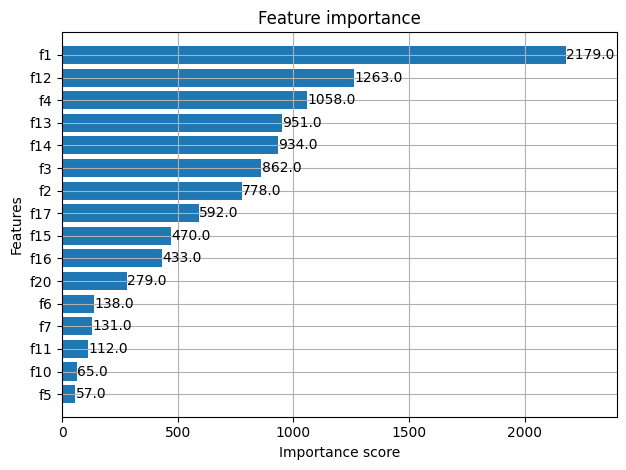

In [9]:
# notebooks/3_model_training.ipynb
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error  # <-- ADD THIS IMPORT
import matplotlib.pyplot as plt

# Load preprocessed data
df = pd.read_csv("../data/processed/walmart_final.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Split data (last 3 months for test)
test_cutoff = df['Date'].max() - pd.DateOffset(months=3)
train = df[df['Date'] < test_cutoff]
test = df[df['Date'] >= test_cutoff]

# Features and target
features = [col for col in df.columns if col not in ['Date', 'Weekly_Sales', 'Store']]
X_train, X_test = train[features], test[features]
y_train, y_test = train['Weekly_Sales'], test['Weekly_Sales']

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Evaluate
test['XGB_Pred'] = model.predict(X_test_scaled)
print(f"XGBoost MAE: ${mean_absolute_error(y_test, test['XGB_Pred']):,.0f}")
print(f"XGBoost RMSE: ${np.sqrt(mean_squared_error(y_test, test['XGB_Pred'])):,.0f}")

# Feature importance
xgb.plot_importance(model, height=0.8)
plt.tight_layout()
plt.savefig("../reports/plots/xgb_feature_importance.png")
plt.show()

In [13]:
# notebooks/3_model_training.ipynb
from prophet import Prophet
import pandas as pd

# Load data
df = pd.read_csv("../data/processed/walmart_final.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Split data
test_cutoff = df['Date'].max() - pd.DateOffset(months=3)
train = df[df['Date'] < test_cutoff]
test = df[df['Date'] >= test_cutoff]

def train_prophet(store_data):
    # Prepare DataFrame with required columns
    prophet_df = store_data[['Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'CPI']].copy()
    prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    
    # Initialize model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    
    # Add regressors (must match columns in prophet_df)
    model.add_regressor('Holiday_Flag')
    model.add_regressor('Temperature')
    model.add_regressor('CPI')
    
    return model.fit(prophet_df)

# Train per-store
prophet_models = {}
stores = df['Store'].unique()

for store in stores:
    try:
        store_data = train[train['Store'] == store]
        prophet_models[store] = train_prophet(store_data)
        print(f"Successfully trained Prophet for Store {store}")
    except Exception as e:
        print(f"Failed for Store {store}: {str(e)}")
        continue

# Generate predictions
prophet_preds = []
for store in test['Store'].unique():
    if store in prophet_models:
        future = test[test['Store'] == store][['Date', 'Holiday_Flag', 'Temperature', 'CPI']]
        future = future.rename(columns={'Date': 'ds'})
        forecast = prophet_models[store].predict(future)
        prophet_preds.extend(forecast['yhat'].values)
    else:
        prophet_preds.extend([None] * len(test[test['Store'] == store]))

test['Prophet_Pred'] = prophet_preds

# Evaluation
valid_preds = test[test['Prophet_Pred'].notnull()]
if len(valid_preds) > 0:
    from sklearn.metrics import mean_absolute_error
    print(f"Prophet MAE: {mean_absolute_error(valid_preds['Weekly_Sales'], valid_preds['Prophet_Pred']):,.0f}")
else:
    print("No valid predictions generated")

11:59:22 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 1


11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 2


11:59:27 - cmdstanpy - INFO - Chain [1] done processing
11:59:27 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 3


11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 4


11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:44 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 5


11:59:45 - cmdstanpy - INFO - Chain [1] done processing
11:59:45 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 6


11:59:45 - cmdstanpy - INFO - Chain [1] done processing
11:59:45 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 7


12:00:01 - cmdstanpy - INFO - Chain [1] done processing
12:00:01 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 8


12:00:02 - cmdstanpy - INFO - Chain [1] done processing
12:00:02 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 9


12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 10


12:00:21 - cmdstanpy - INFO - Chain [1] done processing
12:00:21 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 11


12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 12


12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 13


12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 14


12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 15


12:01:11 - cmdstanpy - INFO - Chain [1] done processing
12:01:11 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 16


12:01:13 - cmdstanpy - INFO - Chain [1] done processing
12:01:13 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 17


12:01:14 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 18


12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 19


12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 20


12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 21


12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 22


12:01:31 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 23


12:01:32 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 24


12:01:33 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 25


12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 26


12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 27


12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 28


12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 29


12:01:59 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 30


12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 31


12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 32


12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 33


12:02:18 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 34


12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 35


12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 36


12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 37


12:02:34 - cmdstanpy - INFO - Chain [1] done processing
12:02:34 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 38


12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 39


12:02:39 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 40


12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 41


12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 42


12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 43


12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing


Successfully trained Prophet for Store 44


12:03:45 - cmdstanpy - INFO - Chain [1] done processing


Successfully trained Prophet for Store 45
Prophet MAE: 833,899


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3836\622139088.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prophet_Pred'] = prophet_preds


Model Comparison Results:
     Model            MAE
0  Prophet  833898.745216


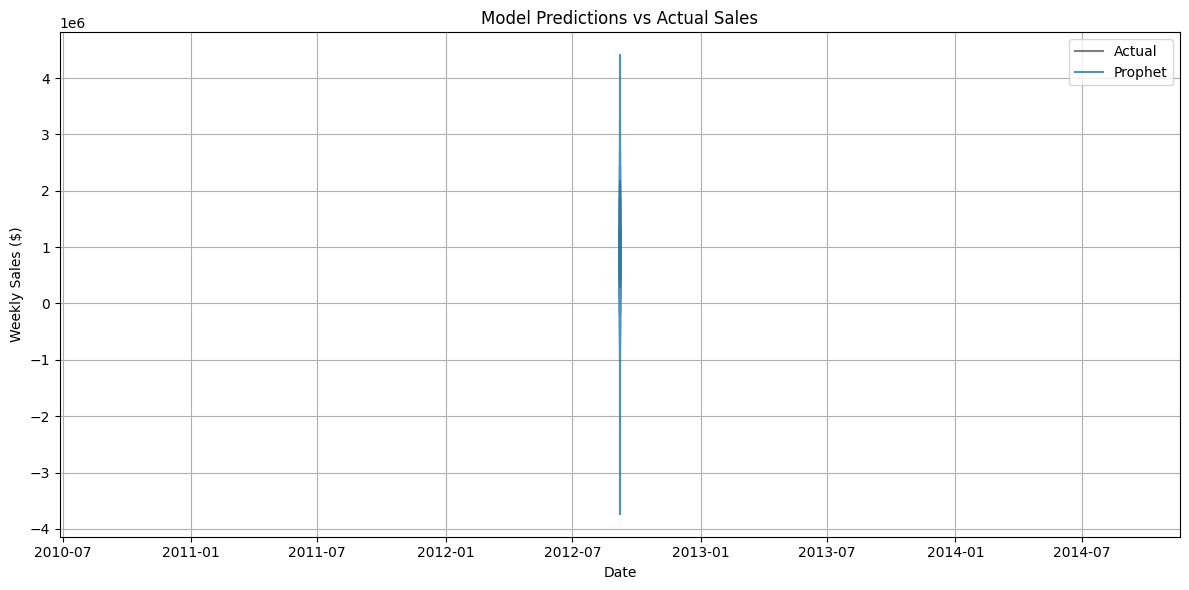

In [18]:
# notebooks/3_model_training.ipynb
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Initialize results dictionary
results = {'Model': [], 'MAE': []}

# Check and add SARIMA results if available
if 'SARIMA_Pred' in test.columns and test['SARIMA_Pred'].notnull().any():
    results['Model'].append('SARIMA')
    results['MAE'].append(mean_absolute_error(
        test['Weekly_Sales'], 
        test['SARIMA_Pred']
    ))

# Check and add XGBoost results if available
if 'XGB_Pred' in test.columns and test['XGB_Pred'].notnull().any():
    results['Model'].append('XGBoost')
    results['MAE'].append(mean_absolute_error(
        test['Weekly_Sales'], 
        test['XGB_Pred']
    ))

# Check and add Prophet results if available
if 'Prophet_Pred' in test.columns and test['Prophet_Pred'].notnull().any():
    results['Model'].append('Prophet')
    results['MAE'].append(mean_absolute_error(
        test['Weekly_Sales'], 
        test['Prophet_Pred']
    ))

# Create DataFrame and sort by MAE (lower is better)
results_df = pd.DataFrame(results).sort_values('MAE')
print("Model Comparison Results:")
print(results_df)

# Visual comparison (only plot models that have predictions)
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Weekly_Sales'], label='Actual', color='black', alpha=0.5)

if 'XGB_Pred' in test.columns:
    plt.plot(test['Date'], test['XGB_Pred'], label='XGBoost', alpha=0.8)

if 'Prophet_Pred' in test.columns:
    plt.plot(test['Date'], test['Prophet_Pred'], label='Prophet', alpha=0.8)

if 'SARIMA_Pred' in test.columns:
    plt.plot(test['Date'], test['SARIMA_Pred'], label='SARIMA', alpha=0.8)

plt.title("Model Predictions vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/plots/model_comparison.png")
plt.show()

In [19]:
print("Available columns:", test.columns.tolist())

Available columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Quarter', 'Is_month_end', 'Day_sin', 'day_cos', 'Month_sin', 'Month_cos', 'Lag_1', 'Rolling_4', 'Rolling_12', 'Fuel_Change', 'CPI_Change', 'Unemployment_Rel', 'Month', 'Week', 'Is_Thanksgiving', 'Is_Christmas', 'Prophet_Pred']


In [20]:
if 'SARIMA_Pred' in test.columns:
    print("SARIMA nulls:", test['SARIMA_Pred'].isnull().sum())

In [21]:
if 'XGB_Pred' in test.columns:
    print("XGBoost sample predictions:", test['XGB_Pred'].head())

In [15]:
print(df[['Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'CPI']].head())

        Date  Weekly_Sales  Holiday_Flag  Temperature         CPI
0 2010-09-10    1507460.69             1        78.69  211.495190
1 2010-11-26    1955624.11             1        64.52  211.748433
2 2010-12-31    1367320.01             1        48.43  211.404932
3 2011-02-11    1649614.93             1        36.39  212.936705
4 2011-09-09    1540471.24             1        76.00  215.861056


In [16]:
print(df[['Holiday_Flag', 'Temperature', 'CPI']].isnull().sum())

Holiday_Flag    0
Temperature     0
CPI             0
dtype: int64
